# DDPLKO Moduł 4 - praca domowa - Quickdraw 10 class - regularyzacja

Twoim zadaniem w tym module będzie przygotowanie własnego modelu sieci neuronowej korzystając z regularyzacji.

Lista rzeczy które musi spełnić Twój model:
- [x] działać na wybranych przez Ciebie 10 klasach (bazuj na kodzie z modułu 3)
- [ ] liczba parametrów pomiędzy 100'000 a 200'000
- [ ] wykorzystane przynajmniej 2 sposoby walki z regularyzacją
- [ ] mieć wykonane co najmniej 4 zmiany w celu poprawy wyniku; zachowaj wszystkie iteracje (modyfikując model możesz dodać opcje w funkji, bądź skopiować klasę/funkcję, tak by było widać kolejne architektury)
- [ ] opisz co chcesz sprawdzić w kolejnych eksperymentach (np. sprawdzę czy Dropout pomaga i z jaką wartością drop ratio najbardziej)
- [ ] uzyskiwać lepsze `validation accuracy` niż w przypadku pierwszego modelu z poprzedniego modułu (im więcej punktów procentowych różnicy tym lepiej)

Zwizualizuj proszę:
- [ ] historie treningów (wystarczy Val acc, ale train acc czy lossy też mogą być)
- [ ] zależność: liczba parametrów - val acc

Możesz (czyli opcjonalne rzeczy):
- pracować na zmniejszonym zbiorze, by dobrać wartość parametrów
- np. zastosować dropout, pooling i early stopping
- zastosować TF2 - Keras / PyTorcha czy PL (Pytorch Lightning)
- dodać LR scheduler do swojego treningu (i sprawdzić czy to poprawiło wynik)
- zwizualizować dodatkowo:
  - confussion matrix
  - błędne przypadki

Warto:
- zmieniać 1 parametr między eksperymentami (szczególnie trudne gdy się już nabierze wyczucia)

In [1]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import os

## 10 wybranych klas

In [2]:
class_names=['donut', 'alarm clock', 'baseball', 'blueberry', 'cookie', 
             'compass', 'hamburger', 'soccer ball', 'wheel', 'watermelon']

## Wczytanie danych

In [3]:
for name in class_names:
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%name
    file_name = url.split('/')[-1].split('?')[0]

    url = url.replace(' ','%20')
    
    if not os.path.isfile(file_name):
        print(url, '==>', file_name)
        urllib.request.urlretrieve(url, file_name)

In [4]:
data = []
for name in class_names:
    file_name = name+'.npy'
    data.append(np.load(file_name, fix_imports=True, allow_pickle=True))
    print('%-15s'%name,type(data[-1]))

donut           <class 'numpy.ndarray'>
alarm clock     <class 'numpy.ndarray'>
baseball        <class 'numpy.ndarray'>
blueberry       <class 'numpy.ndarray'>
cookie          <class 'numpy.ndarray'>
compass         <class 'numpy.ndarray'>
hamburger       <class 'numpy.ndarray'>
soccer ball     <class 'numpy.ndarray'>
wheel           <class 'numpy.ndarray'>
watermelon      <class 'numpy.ndarray'>


In [5]:
test_data = [data[idx][int(0.25*len(data[idx])):int(0.28*len(data[idx]))] for idx in range(len(data))]
data = [data[idx][:int(0.25*len(data[idx]))] for idx in range(len(data))]

In [6]:
# Konwersja danych do formatu torch'a
X = np.reshape((np.concatenate(data)), (-1, 28, 28, 1))
y = np.concatenate([[idx]*len(category) for idx, category in enumerate(data)])

In [74]:
# test data
X_test = np.reshape((np.concatenate(test_data)), (-1, 28, 28, 1))
y_test = np.concatenate([[idx]*len(category) for idx, category in enumerate(test_data)])

In [75]:
# Normalizacja danych
X = X / 255
X_test = X_test / 255

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
                        X, y, train_size=0.8, test_size=0.2, stratify=y)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms
from tqdm import tqdm 

In [13]:
# Pierwszy model ze zwiększoną liczbą filtrów w warstwach Conv2d
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(25600, 10)
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

In [11]:
def count_model_params(model) -> None:
    """Counts model's parameters"""
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f'Params: {params}, {model._get_name()}')

In [29]:
n = Net()
x = torch.randn(1, 1, 28, 28)
out = n(x)
out.shape # check flattened vector shape

torch.Size([1, 25600])

In [11]:
torch.cuda.is_available()

True

In [12]:
X_train=torch.from_numpy(np.transpose((X_train), (0, 3, 1, 2))).to(torch.float32)
X_val=torch.from_numpy(np.transpose((X_val), (0, 3, 1, 2))).to(torch.float32)
y_train=torch.from_numpy(y_train)
y_val=torch.from_numpy(y_val)
X_test = torch.from_numpy(np.transpose((X_test), (0, 3, 1, 2))).to(torch.float32)
y_test=torch.from_numpy(y_test)


def torch_train(model, optimizer, early_stopping: bool, epochs: int, 
                batch_size: int, patience=3, save_models=False) -> dict:
    """Trains torch model"""
    device = torch.device('cuda')
    print(device)
    
    epochs = epochs
    batch_size = batch_size

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    
    current_patience = 0
    highest_acc = 0
    for epoch in tqdm(list(range(1, epochs + 1))):
        model.train()
        train_loss=0
        correct=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().detach()
            train_loss+=loss.detach()
        train_loss/=len(train_loader)
        acc = correct / float(len(train_loader.dataset))
        train_losses.append(train_loss)
        train_accs.append(acc)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.nll_loss(output, target, reduction='sum').detach()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().detach()


        val_loss /= len(val_loader.dataset)
        val_acc = correct / float(len(val_loader.dataset))
        
        # early stopping
        
        if early_stopping:
            if val_acc > highest_acc:
                highest_acc = val_acc
                current_patience = 0
                
            if len(val_accs) > 0:
                if val_acc < highest_acc:
                    current_patience += 1
                    if current_patience == patience:
                        print(f'Early stopped at {epoch} epoch. Current val_acc: {val_acc}. Last val_acc: {val_accs[-1]}')
                        break
                        
        if save_models:
            if len(val_accs) > 0:
                if val_acc > max(val_accs):
                    torch.save(model.state_dict(), f'./{epoch}_epoch_model.pt')
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
    return train_losses, train_accs, val_losses, val_accs

In [16]:
model = Net()
results = []
models = ['First model']
count_model_params(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scores = torch_train(model, optimizer, early_stopping=False, epochs=10, batch_size=512)
results.append(scores)

Params: 280394, Net
None
cuda


100%|██████████| 10/10 [03:01<00:00, 18.16s/it]


In [13]:
%matplotlib inline

def plot_results(results: list, labels: list) -> None:
    """plots training metrics"""
    
    metrics = ['train loss', 'train acc', 'val loss', 'val acc']
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    if len(labels) == 1:
        srtd = sorted(zip(results, labels), key=lambda x: max(x[0]), reverse=True)
    else:
        srtd = sorted(zip(results, labels), key=lambda x: max(x[0][3]), reverse=True)       
        
    
    for model_scores, label in srtd:
        for result, metric in zip(model_scores, metrics):
            
            
            row = int((metric.split(' ')[0] == 'val'))
            col = int((metric.split(' ')[1] == 'acc'))
            result = [_.cpu() for _ in result]
            if metric.split(' ')[1] == 'acc':
                axs[row, col].plot(result, label='{} {:.2f}%'.format(label, 100*max(result)))
            else:
                axs[row, col].plot(result, label='{} {:.2f}'.format(label, min(result)))
                
            axs[row, col].set_title(metric)
            axs[row, col].legend()
    plt.tight_layout()



## Model z poprzedniej pracy domowej

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc = nn.Linear(15488, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [30]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scores = torch_train(model, optimizer, early_stopping=False, epochs=10, batch_size=512)

cuda


100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


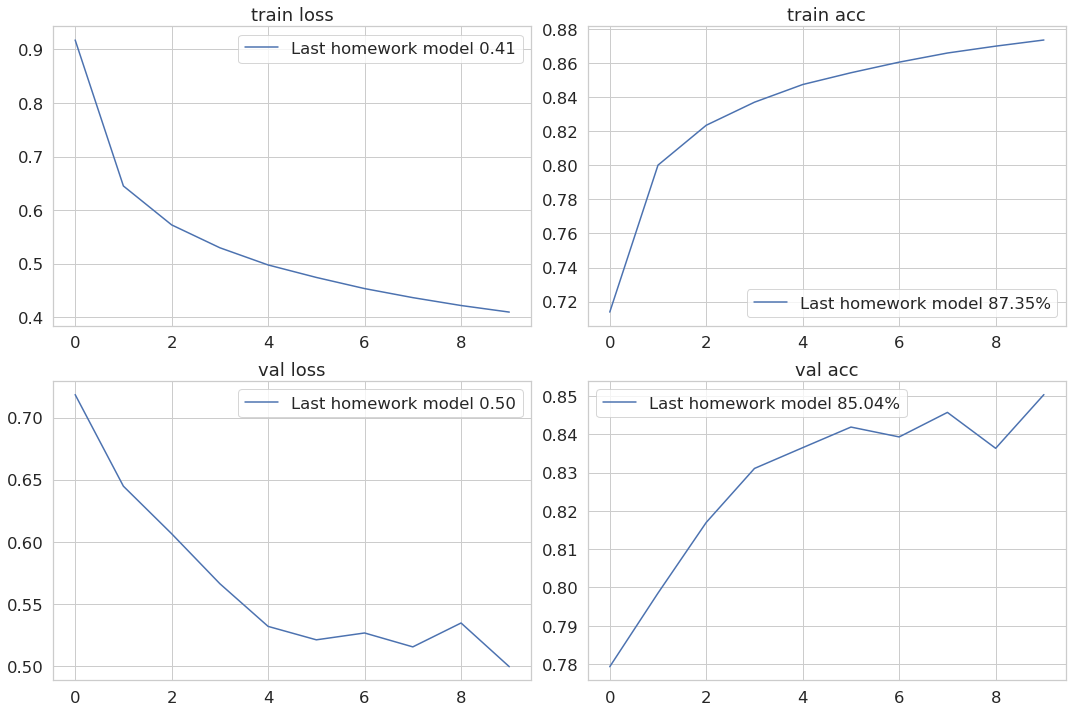

In [32]:
plot_results([scores], labels=['Last homework model'])

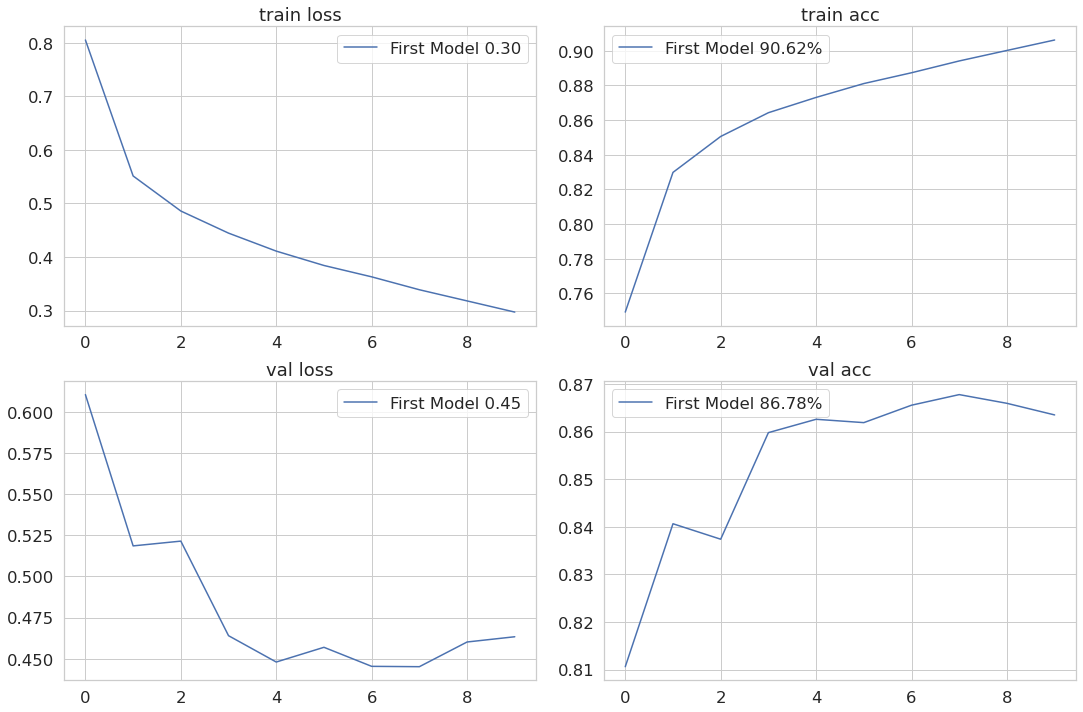

In [142]:
plot_results(results, labels=['First Improved Model'])

# Sprawdzenie różnych kombinacji dropout'u

In [ ]:
class Net(nn.Module):
    def __init__(self, ratios):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Dropout(ratios[0]),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Dropout(ratios[1]),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Dropout(ratios[2]),
            nn.Flatten(),
            nn.Linear(25600, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
dropout_ratios = [[0.1, 0, 0], [0.3, 0, 0], [0, 0.2, 0], [0.1, 0.1, 0.1], [0.2, 0.2, 0.2], [0, 0, 0.3]]

for ratios in dropout_ratios:
    model = Net(ratios)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    score = torch_train(model, optimizer, early_stopping=True, epochs=10, batch_size=512)
    results.append(score)


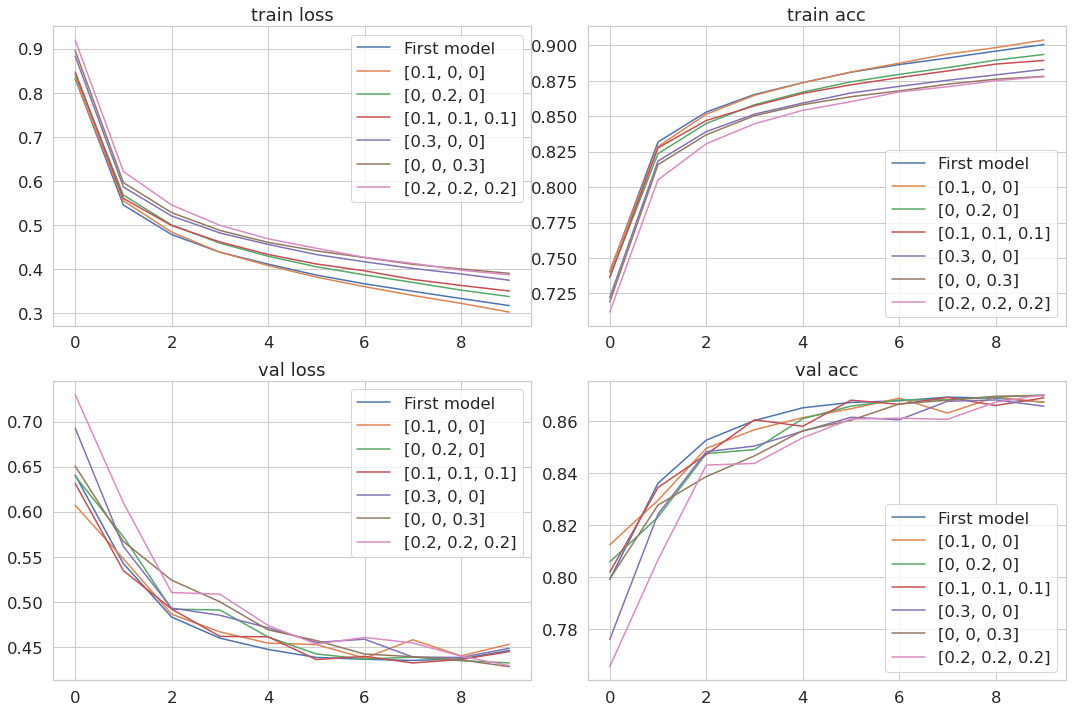

In [108]:
plot_results(results, models)

### Dodanie dropout'u w aktualnej konfiguracji nie przyniosło zauważalnej poprawy wyników

# Sprawdzenie wyników po dodaniu pooling'u

In [17]:
class NetMaxPooling(nn.Module):
    def __init__(self):
        super(NetMaxPooling, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class NetAvgPooling(nn.Module):
    def __init__(self):
        super(NetAvgPooling, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class NetCNNPooling(nn.Module):
    def __init__(self):
        super(NetCNNPooling, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class NetGlobalMaxPooling(nn.Module):
    def __init__(self):
        super(NetGlobalMaxPooling, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class NetGlobalAvgPooling(nn.Module):
    def __init__(self):
        super(NetGlobalAvgPooling, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

In [118]:
# device = torch.device('cuda')
n = NetMaxPooling()
x = torch.randn(1, 1, 28, 28)
out = n(x)
del n
out.shape # check flattened vector shape

torch.Size([1, 256])

In [18]:
models = [NetMaxPooling,
         NetAvgPooling,
         NetCNNPooling,
         NetGlobalMaxPooling,
         NetGlobalAvgPooling]

for net in models:
    model = net()
    count_model_params(model)

Params: 106298, NetMaxPooling
Params: 106298, NetAvgPooling
Params: 106298, NetCNNPooling
Params: 171194, NetGlobalMaxPooling
Params: 171194, NetGlobalAvgPooling


In [ ]:
pooling_results = []
for net in models:
    model = net()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    score = torch_train(model, optimizer, early_stopping=True, epochs=10, batch_size=512)
    pooling_results.append(score) 

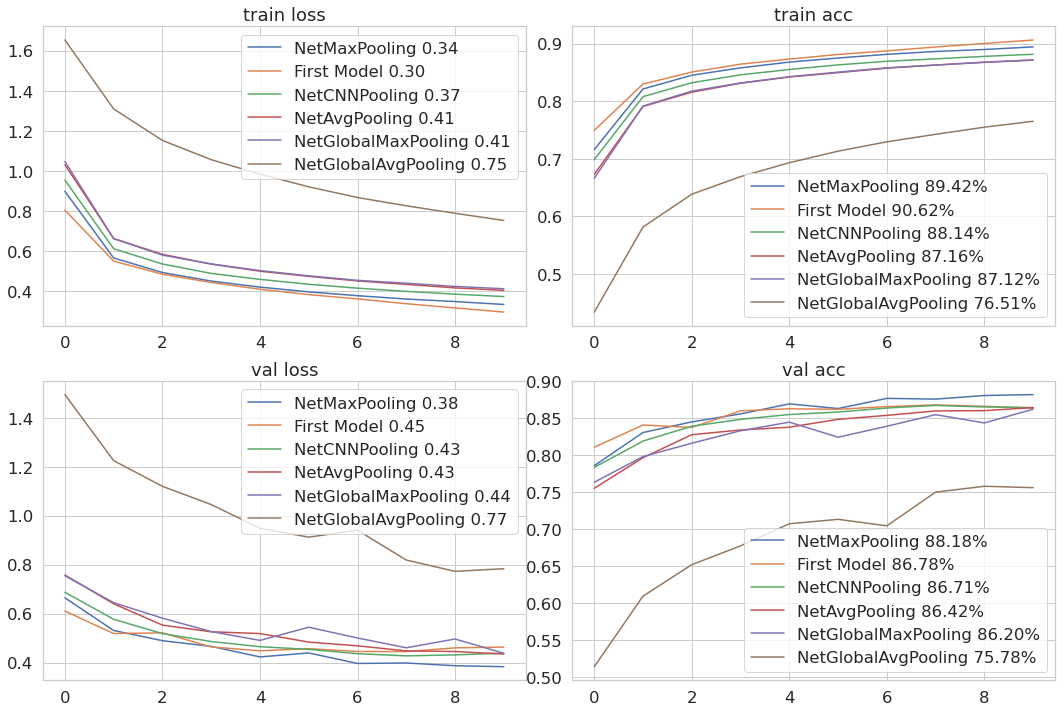

In [128]:
pooling_models = [_.__name__ for _ in models]
# pooling_results.append(results[0])
plot_results(pooling_results, pooling_models)

## Dłuższy trening najlepszego modelu

In [147]:
model = NetMaxPooling()
optimizer = optim.Adam(model.parameters(), lr=0.001)
score = torch_train(model, optimizer, early_stopping=True, epochs=20, batch_size=512, patience=5)

cuda


100%|██████████| 20/20 [04:40<00:00, 14.05s/it]


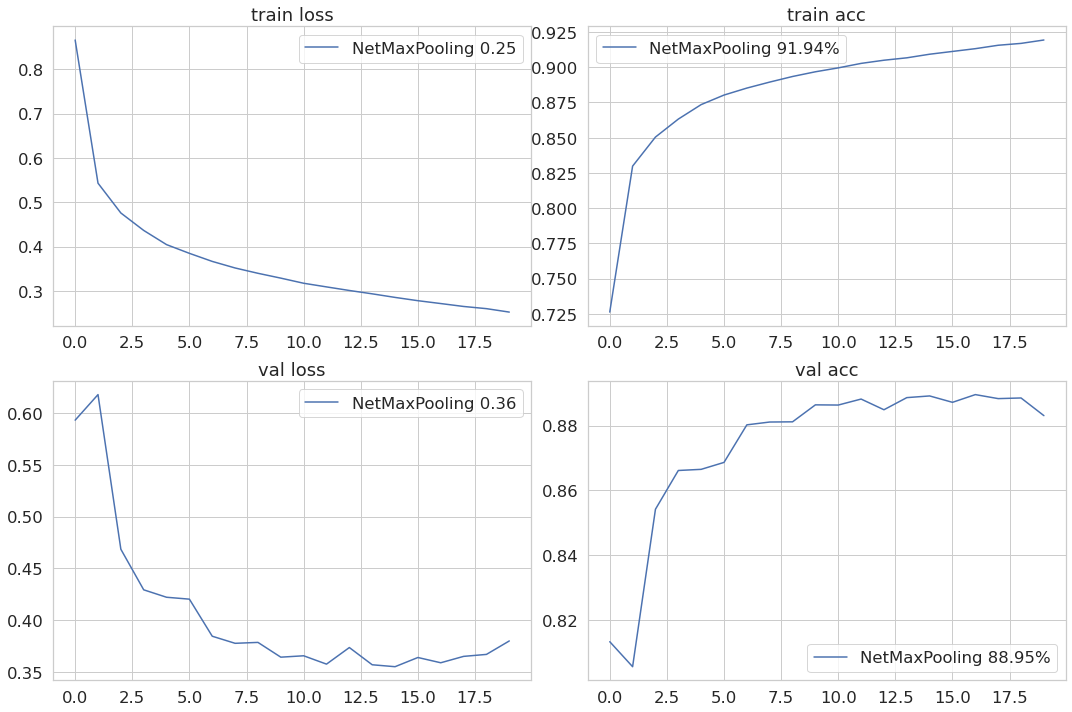

In [148]:
plot_results([score], [model._get_name()])

## Sprawdzenie wpływu Batch Normalization

In [14]:
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class NetBN2(nn.Module):
    def __init__(self):
        super(NetBN2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class NetBN3(nn.Module):
    def __init__(self):
        super(NetBN3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class NetBN4(nn.Module):
    def __init__(self):
        super(NetBN4, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(1152, 10)
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

In [153]:
models = [NetBN,
         NetBN2,
         NetBN3,
         NetBN4]
bn_scores = []

for net in models:
    model = net()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    score = torch_train(model, optimizer, early_stopping=True, epochs=20, batch_size=512)
    bn_scores.append(score)

cuda


 60%|██████    | 12/20 [03:10<02:06, 15.87s/it]


Early stopped at 13 epoch. Current val_acc: 0.887595534324646. Last val_acc: 0.8862225413322449
cuda


 40%|████      | 8/20 [02:13<03:20, 16.73s/it]


Early stopped at 9 epoch. Current val_acc: 0.8900059461593628. Last val_acc: 0.8863293528556824
cuda


 45%|████▌     | 9/20 [02:30<03:03, 16.71s/it]


Early stopped at 10 epoch. Current val_acc: 0.8890296220779419. Last val_acc: 0.888312578201294
cuda


 45%|████▌     | 9/20 [02:32<03:06, 16.93s/it]

Early stopped at 10 epoch. Current val_acc: 0.8861615061759949. Last val_acc: 0.888343095779419


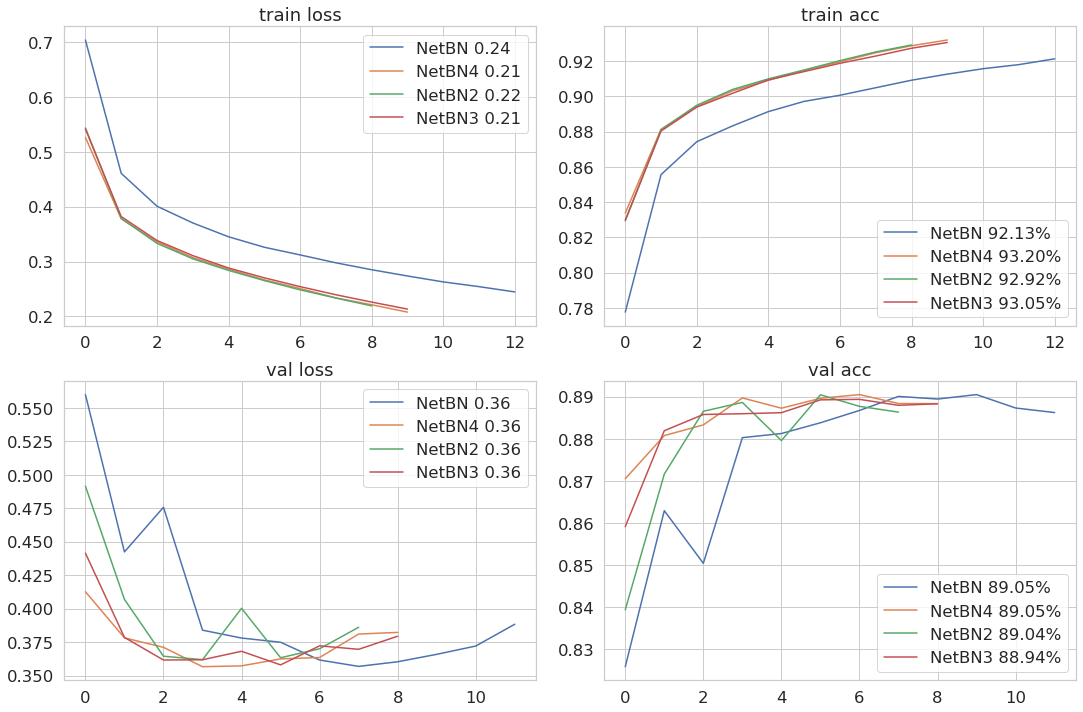

In [154]:
bn_models = [_.__name__ for _ in models]
plot_results(bn_scores, bn_models)

## Sprawdzenie wpływu weight decay

In [15]:
weight_decays=[0,0.1,0.01,0.001,0.0001]

w_decay_results = []
for weight_decay in weight_decays:
    model = NetBN()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    score = torch_train(model, optimizer, early_stopping=True, epochs=10, batch_size=512)
    w_decay_results.append(score)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]/home/jakub/anaconda3/envs/deep_learning/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 70%|███████   | 7/10 [01:57<00:50, 16.78s/it]


Early stopped at 8 epoch. Current val_acc: 0.885002076625824. Last val_acc: 0.8834917545318604
cuda


 90%|█████████ | 9/10 [02:28<00:16, 16.52s/it]


Early stopped at 10 epoch. Current val_acc: 0.7176005840301514. Last val_acc: 0.7170513868331909
cuda


100%|██████████| 10/10 [02:23<00:00, 14.31s/it]


cuda


100%|██████████| 10/10 [02:23<00:00, 14.35s/it]


cuda


 90%|█████████ | 9/10 [02:23<00:15, 15.94s/it]

Early stopped at 10 epoch. Current val_acc: 0.8910738825798035. Last val_acc: 0.8910128474235535


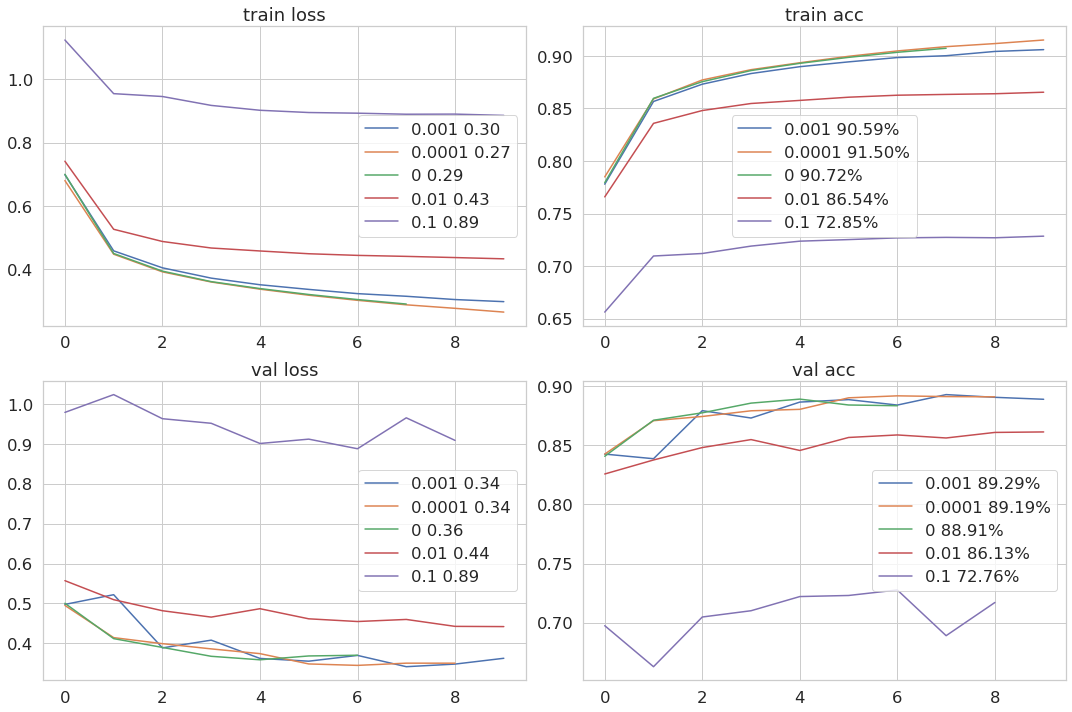

In [16]:
w_decay_models = [str(_) for _ in weight_decays]
plot_results(w_decay_results, w_decay_models)

## Sprawdzenie różnych optymalizatorów wykorzystując scheduler do optymalizacji lr

In [28]:
import torch_optimizer as optim
device = torch.device('cuda')

optims = [optim.adabound.AdaBound,
         optim.qhadam.QHAdam,
         optim.adamod.AdaMod,
         optim.swats.SWATS,
         torch.optim.Adam]

min_lr=1e-5
max_lr=10
epochs=30
batch_size = 512

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

steps=(epochs-1)*len(train_loader)
lr_lambda = lambda epoch: min_lr * 10**((np.log10(max_lr)-np.log10(min_lr)) * (epoch) / float(steps))



results = []
for opt in optims:
    print(str(opt))
    model = NetBN().to(device)
    lrs = []
    optimizer = opt(model.parameters(), lr=1)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    
    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]
    
    for epoch in range(1, epochs + 1):
        lr=scheduler.get_last_lr()
        lrs.append(lr[0])
        model.train()
        train_correct=0
        train_loss=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            pred = output.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(target.view_as(pred)).sum().detach()
            train_loss+=loss.detach()
            
        train_loss/=len(train_loader)
        acc = train_correct / float(len(train_loader.dataset))
        train_losses.append(train_loss)
        train_accs.append(acc)
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.nll_loss(output, target, reduction='sum').detach()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().detach()


        val_loss /= len(val_loader.dataset)
        val_acc = correct / float(len(val_loader.dataset))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print("LR %.2e Train loss: %f Acc: %f Val   loss: %f Acc: %f"%(lr[0], train_loss, acc, val_loss, val_acc))        
    results.append((lrs, train_losses,val_losses,train_accs,val_accs))


<class 'torch_optimizer.adabound.AdaBound'>
LR 1.00e-05 Train loss: 2.303701 Acc: 0.086009 Val   loss: 2.303267 Acc: 0.087385
LR 1.61e-05 Train loss: 2.303463 Acc: 0.086696 Val   loss: 2.303061 Acc: 0.088117
LR 2.59e-05 Train loss: 2.303255 Acc: 0.087650 Val   loss: 2.302809 Acc: 0.089063
LR 4.18e-05 Train loss: 2.302894 Acc: 0.088809 Val   loss: 2.302442 Acc: 0.090436
LR 6.72e-05 Train loss: 2.302483 Acc: 0.090251 Val   loss: 2.301898 Acc: 0.092541
LR 1.08e-04 Train loss: 2.301843 Acc: 0.093107 Val   loss: 2.301116 Acc: 0.095608
LR 1.74e-04 Train loss: 2.300860 Acc: 0.097276 Val   loss: 2.299893 Acc: 0.099101
LR 2.81e-04 Train loss: 2.299333 Acc: 0.103638 Val   loss: 2.298074 Acc: 0.106500
LR 4.52e-04 Train loss: 2.297114 Acc: 0.113241 Val   loss: 2.295305 Acc: 0.116798
LR 7.28e-04 Train loss: 2.293698 Acc: 0.123600 Val   loss: 2.291106 Acc: 0.127172
LR 1.17e-03 Train loss: 2.288494 Acc: 0.133597 Val   loss: 2.284636 Acc: 0.139667
LR 1.89e-03 Train loss: 2.280279 Acc: 0.148269 Val   l

LR 4.52e-04 Train loss: 0.489425 Acc: 0.847177 Val   loss: 0.468358 Acc: 0.852950
LR 7.28e-04 Train loss: 0.449868 Acc: 0.859832 Val   loss: 0.435171 Acc: 0.863125
LR 1.17e-03 Train loss: 0.418126 Acc: 0.869050 Val   loss: 0.431070 Acc: 0.863217
LR 1.89e-03 Train loss: 0.387113 Acc: 0.878238 Val   loss: 0.387068 Acc: 0.877817
LR 3.04e-03 Train loss: 0.371195 Acc: 0.882895 Val   loss: 0.380595 Acc: 0.879525
LR 4.89e-03 Train loss: 0.358753 Acc: 0.886034 Val   loss: 0.457255 Acc: 0.856504
LR 7.88e-03 Train loss: 0.356064 Acc: 0.887365 Val   loss: 0.433826 Acc: 0.861554
LR 1.27e-02 Train loss: 0.357685 Acc: 0.886316 Val   loss: 0.498663 Acc: 0.838106
LR 2.04e-02 Train loss: 0.394169 Acc: 0.875881 Val   loss: 0.488873 Acc: 0.860410
LR 3.29e-02 Train loss: 2.417478 Acc: 0.124203 Val   loss: 2.303961 Acc: 0.100200
LR 5.30e-02 Train loss: 2.303912 Acc: 0.103340 Val   loss: 2.305279 Acc: 0.098918
LR 8.53e-02 Train loss: 2.305228 Acc: 0.103165 Val   loss: 2.304998 Acc: 0.104243
LR 1.37e-01 Trai

In [45]:
optims_lrs = []
for optim, (lrs, _, _, _, val_accs) in zip(optims, results):
    print(optim.__module__.split('.')[-1], f'Best val acc: {float(max(val_accs))} at LR {lrs[val_accs.index(max(val_accs))]}')
    optims_lrs.append((optim, lrs[val_accs.index(max(val_accs))]))

adabound Best val acc: 0.8846359252929688 at LR 3.8566204211634725
qhadam Best val acc: 0.8769317865371704 at LR 0.007880462815669913
adamod Best val acc: 0.8848190307617188 at LR 0.007880462815669913
swats Best val acc: 0.8795252442359924 at LR 0.003039195382313198
adam Best val acc: 0.8811423778533936 at LR 0.007880462815669913


In [51]:
optims_scores = []
for opt, lr in optims_lrs:
    model = NetBN()
    optimizer = opt(model.parameters(), lr=lr, weight_decay=0.001)
    score = torch_train(model, optimizer, early_stopping=True, epochs=10, batch_size=512)
    optims_scores.append(score)

cuda


100%|██████████| 10/10 [02:21<00:00, 14.16s/it]


cuda


100%|██████████| 10/10 [02:28<00:00, 14.89s/it]


cuda


 70%|███████   | 7/10 [01:55<00:49, 16.45s/it]


Early stopped at 8 epoch. Current val_acc: 0.8912111520767212. Last val_acc: 0.890463650226593
cuda


 50%|█████     | 5/10 [01:46<01:46, 21.26s/it]


Early stopped at 6 epoch. Current val_acc: 0.8671223521232605. Last val_acc: 0.8699598908424377
cuda


 70%|███████   | 7/10 [01:54<00:48, 16.31s/it]

Early stopped at 8 epoch. Current val_acc: 0.8106759786605835. Last val_acc: 0.8191124200820923


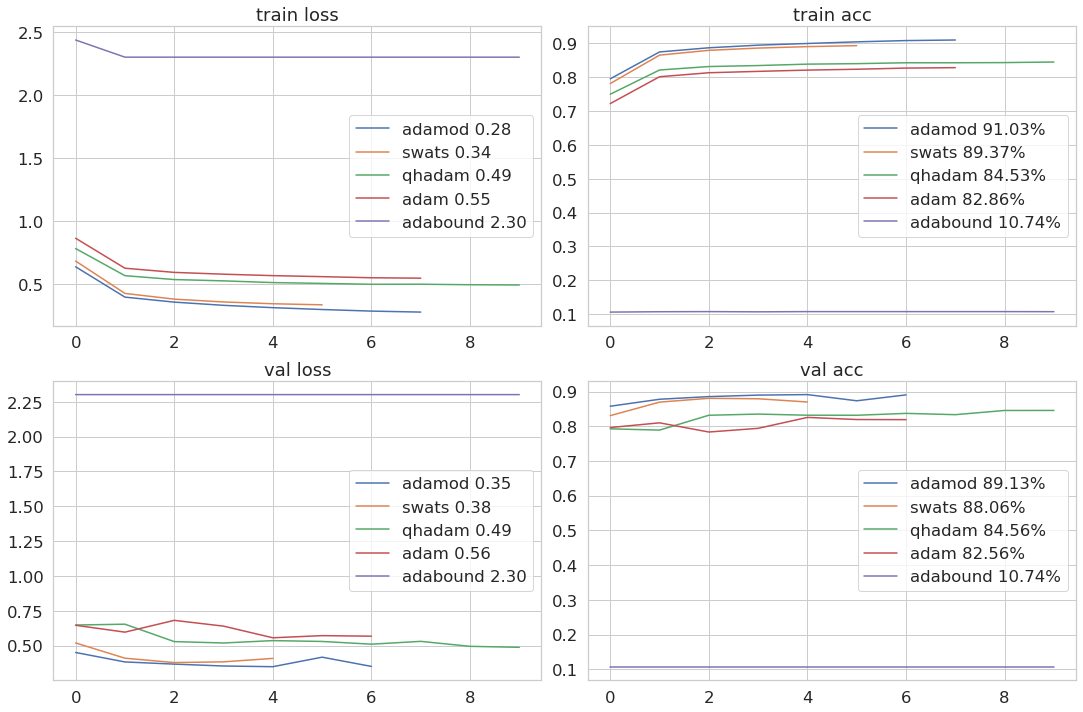

In [52]:
optim_names = [str(opt.__module__).split('.')[-1] for opt in optims]

plot_results(optims_scores, optim_names)

## Finalny model

In [26]:
model = NetBN()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
score = torch_train(model, optimizer, early_stopping=True, epochs=10, batch_size=512, save_models=True)


cuda


100%|██████████| 10/10 [02:31<00:00, 15.18s/it]


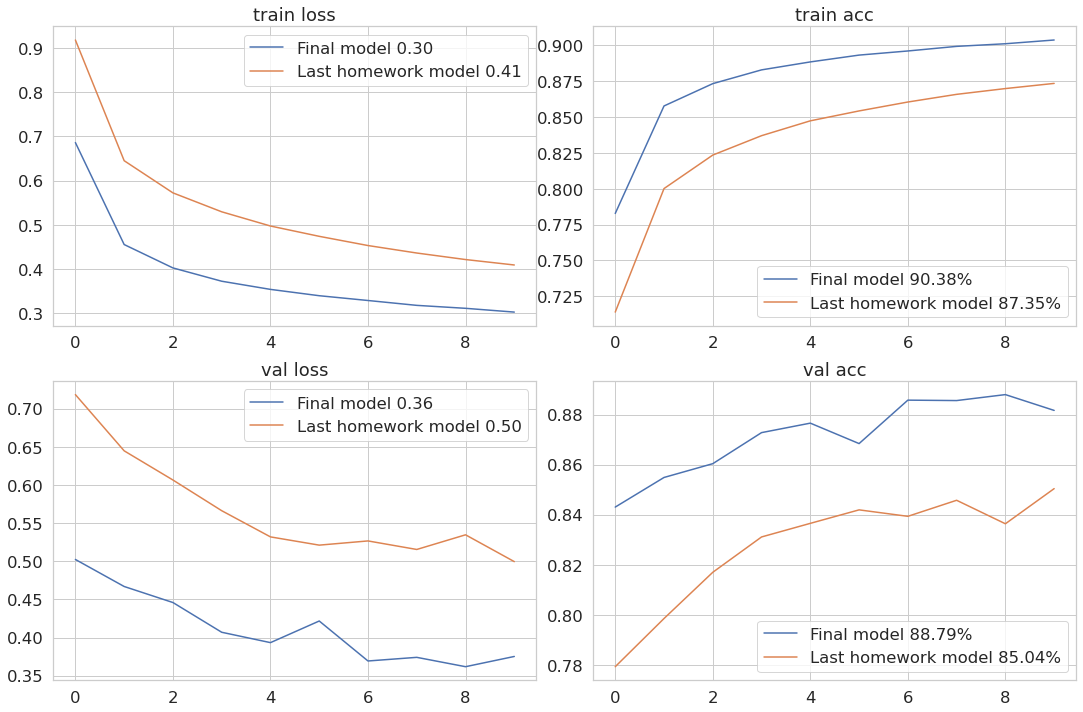

In [33]:
plot_results([score, scores], ['Final model', 'Last homework model'])

In [79]:
count_model_params(model)
print(model)

Params: 106314, NetBN
NetBN(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=1152, out_features=10, bias=True)
  )
)


## Model test

In [15]:
model = NetBN()
model.load_state_dict(torch.load('./9_epoch_model.pth'))

<All keys matched successfully>

In [108]:
def get_test_examples(x_test: torch.Tensor, y_test: torch.Tensor, examples=50) -> dict:
    classes = [_ for _ in range(10)]
    new_x_test, new_y_test = [], []
    y_test = list(y_test)
    x_test = list(x_test)
    for cls in classes:
        for _ in range(examples // len(classes)):
            cls_idx = y_test.index(cls)
            new_y_test.append(y_test.pop(cls_idx))
            new_x_test.append(x_test.pop(cls_idx))
    

    new_x_test = torch.from_numpy(np.reshape(np.concatenate(new_x_test), (-1, 1, 28, 28))).to(torch.float32)
    y_test=torch.from_numpy(np.array(y_test))
    return new_x_test, new_y_test

In [109]:
new_x_test, new_y_test = get_test_examples(X_test, y_test)

In [110]:
device = torch.device('cuda')
model.to(device)
model.eval()
results = []
new_x_test = new_x_test.to(device)
out = model(new_x_test)

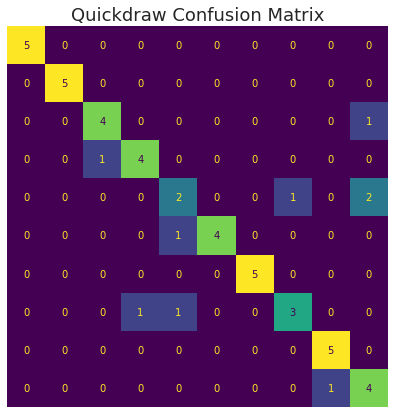

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = [list(_).index(max(_)) for _ in out]

cm = confusion_matrix(new_y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(7, 7))

disp.plot(xticks_rotation = 'vertical', ax=ax, colorbar=False)
ax.set_title('Quickdraw Confusion Matrix')
ax.axis('off');

In [122]:
mistakes = []
mistaken_images = []
for idx, (pred, correct) in enumerate(zip(predictions, new_y_test)):
    if pred != correct:
        mistakes.append((pred, correct))
        mistaken_images.append(new_x_test[idx])
print(f'Total correct: {len(predictions) - len(mistakes)}')
print(f'Total mistakes: {len(mistakes)}')

print('Accuracy: {:.2f}%'.format(100*(1 - len(mistakes) / len(predictions))))

Total correct: 41
Total mistakes: 9
Accuracy: 82.00%


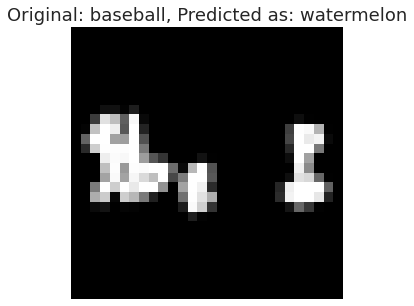

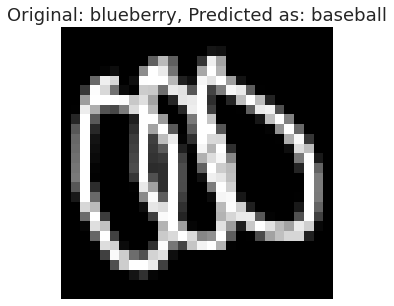

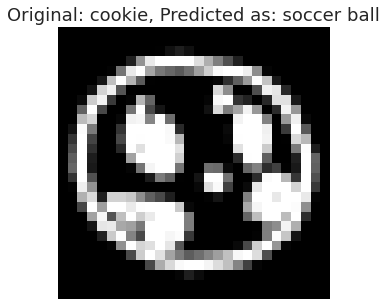

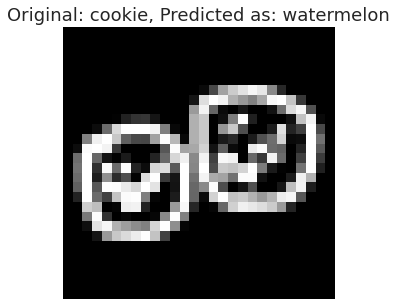

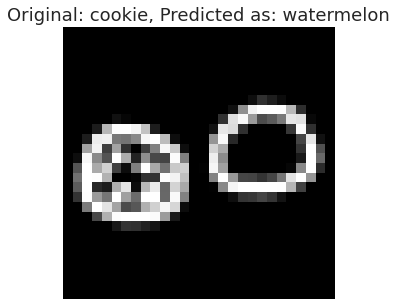

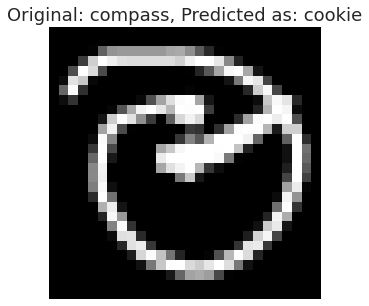

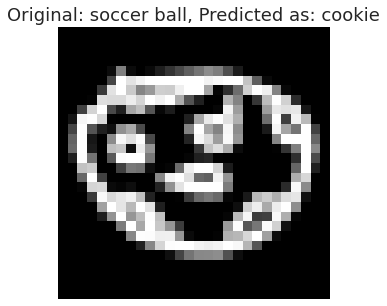

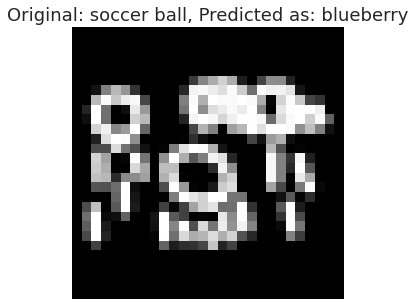

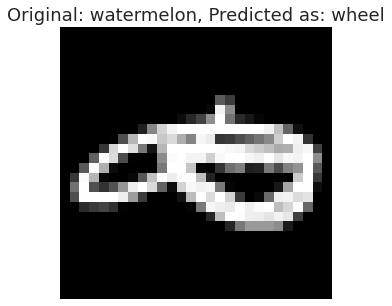

In [134]:
# Mistakes visualisation

for image, (pred, label) in zip(mistaken_images, mistakes):
    image = np.array(image.cpu())
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(np.squeeze(image), cmap='gray')
    plt.title(f'Original: {class_names[label]}, Predicted as: {class_names[pred]}')

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.